In [1]:
! pip install pandas matplotlib python-docx gTTS fpdf2

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from gtts import gTTS
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from fpdf import FPDF
from datetime import datetime
import abc

Archivo 'ventas.xlsx' de muestra creado
[2025-09-07 02:15:55]
Datos cargados exitosamente desde 'ventas.xlsx'
[2025-09-07 02:15:55]
[2025-09-07 02:15:55]
Grafico de Ventas generado y guardado: 'grafico_ventas.png'
[2025-09-07 02:15:55]
Reporte de Word generado y guardado como: 'reporte_ventas.docx'
[2025-09-07 02:15:55]
Audio de resumen de las ventas del mes generado y guardado como: 'resumen_ventas.mp3'


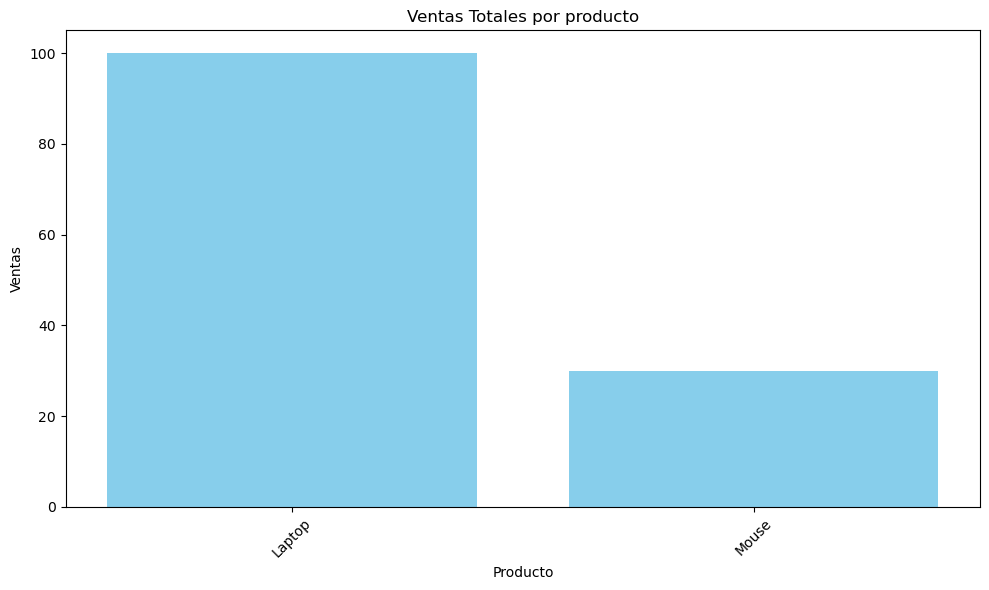

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from gtts import gTTS
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from fpdf import FPDF
from datetime import datetime
import abc

def log_operacion(func):
    def wrapper(self, *args, **kwargs):
        log_entry = f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]"
        self.log_content += log_entry + "\n"
        print(log_entry.strip())
        result = func(self, *args, **kwargs)
        return result
    return wrapper

class ReporteBase(abc.ABC):
    def __init__(self, archivo_excel):
        self.archivo_excel = archivo_excel
        self.dataframe = None
        self.log_content = ""

    @abc.abstractmethod
    def cargar_datos(self):
        pass

    @abc.abstractmethod
    def generar_reporte(self):
        pass

    def exportar_log_pdf(self, nombre_archivo="log_reporte.pdf"):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=10)

        pdf.cell(200, 10, txt="Log de operaciones del Sistema de Reportes", ln=True, align="C")
        pdf.ln(8)

        for line in self.log_content.split('\n'):
            if line:
                pdf.multi_cell(0, 5, txt=line)

        pdf.output(nombre_archivo)
        print(f"Log exportado a '{nombre_archivo}'")

class ReporteVentas(ReporteBase):

    def __init__(self, archivo_excel="ventas.xlsx"):
        super().__init__(archivo_excel)

    @log_operacion
    def cargar_datos(self):
        try:
            self.dataframe = pd.read_excel(self.archivo_excel)
            print(f"Datos cargados exitosamente desde '{self.archivo_excel}'")
            return True
        except FileNotFoundError:
            print(f"Error: El archivo '{self.archivo_excel}' no fue encontrado.")
            return False

    @log_operacion
    def _analizar_datos(self):
        if self.dataframe is None:
            print("Error: No hay ningun dato para analizar")
            return None
        resumen_ventas = self.dataframe.groupby('Producto')['Ventas'].sum().reset_index()
        resumen_ventas = resumen_ventas.sort_values(by='Ventas', ascending=False)
        return resumen_ventas

    @log_operacion
    def _crear_grafico(self, resumen_ventas):
        plt.figure(figsize=(10, 6))
        plt.bar(resumen_ventas['Producto'], resumen_ventas['Ventas'], color='skyblue')
        plt.title('Ventas Totales por producto')
        plt.xlabel('Producto')
        plt.ylabel('Ventas')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('grafico_ventas.png')
        print("Grafico de Ventas generado y guardado: 'grafico_ventas.png'")

    @log_operacion
    def _crear_reporte_word(self, resumen_ventas):
        doc = Document()
        doc.add_heading('Reporte de Ventas Mensuales', 0)
        doc.add_paragraph('Este documento contiene el resumen del rendimiento de ventas del ultimo mes')
        doc.add_heading('Reporte de Ventas por Producto', level=1)
        doc.add_paragraph(resumen_ventas.to_string(index=False))
        doc.add_heading('Visualizacion Grafica', level=1)
        doc.add_picture('grafico_ventas.png', width=Inches(6))
        doc.save('reporte_ventas.docx')
        print("Reporte de Word generado y guardado como: 'reporte_ventas.docx'")

    @log_operacion
    def _crear_audio_resumen(self, resumen_ventas):
        texto_resumen = "Hola, este es el resumen de ventas. Los productos mas vendidos son los siguientes: "
        for _, row in resumen_ventas.head(3).iterrows():
            texto_resumen += f"el {row['Producto']} con {row['Ventas']} unidades vendidas, "
        texto_resumen = texto_resumen.rstrip(', ') + "."
        tts = gTTS(text=texto_resumen, lang='es')
        tts.save("resumen_ventas.mp3")
        print("Audio de resumen de las ventas del mes generado y guardado como: 'resumen_ventas.mp3'")

    def generar_reporte(self):
        if self.cargar_datos():
            resumen = self._analizar_datos()
            if resumen is not None:
                self._crear_grafico(resumen)
                self._crear_reporte_word(resumen)
                self._crear_audio_resumen(resumen)

datos_ejemplo = {
    'Fecha': pd.to_datetime(['2025-08-06', '2025-08-07']),
    'Producto': ['Laptop', 'Mouse'],
    'Ventas':[100, 30]
}

df_ejemplo = pd.DataFrame(datos_ejemplo)
df_ejemplo.to_excel("ventas.xlsx", index=False)

print("Archivo 'ventas.xlsx' de muestra creado")

reporte_ventas = ReporteVentas()
reporte_ventas.generar_reporte()